# B. Knock Down Each Other from Now on

## 알고리즘을 넘은 다음

Ch.19에서 10만판이나 되는 게임을 돌려서 상당히 강력한 AI를 얻는 것은 성공했습니다.
하지만, 아직 스스로는 3-4 공격 등을 제대로 읽지 못하는 등 결점이
많았습니다.
더 강하게 키우기 위해서는 더 강한 적이 필요한데, 이제 알고리즘으로
학습시키는 것은 역부족이므로 학습된 network를 바탕으로
자기들끼리 싸우도록 만듭니다.

그래서 여기서는 Ch.19를 바탕으로 지속적으로 학습할 수 있는
노트북을 만듭니다.

대략적인 학습 방법은 다음과 같습니다.

- `HallOfFame`을 만들어서, *강하다*고 판단되는 신경망을
$N$개 저장해둡니다.
- 새로운 신경망을 학습할 때에는 `HoF`에서 하나를 가져와서 그것을
기반으로 학습을 합니다.
- 학습을 할 때는 `HoF`의 policy들과 기존에 만들어둔 알고리즘
`aa`, `ad`, `df`, `pt`, `mixed`를 순서대로 상대합니다.
- 학습은 정해진 횟수 $B$ 번 대전하며 이루어지는데,
여기서는 이렇게 학습되어 나온 policy network에 `gen(eration)`
을 식별번호처럼 붙이도록 합니다. (Ch.19에서 학습된 것이 `gen=0`, 그 다음 network부터 1씩 늘어납니다.)
- 일단 학습이 완료되었다면 평가를 합니다.
- 우선 5개의 알고리즘과 각각 $A$번 대전해서 승률을 구할 수
있는데, 이 승률이 `HoF`의 network의 알고리즘과의 승률 중
가장 낮은 것에도 미치지 못하면 폐기합니다.
- 이후 `HoF`의 network와 $T$번 대전하여 승률이 $w$ 이하라면
폐기합니다.
- 그 외의 경우에는 `HoF` 중 현재 network와 가장 승률이
낮았던 network를 폐기하고 그 자리를 차지하도록 합니다.

우선은 아래에서는 기존의 코드를 정리하고,
위 학습 방법을 정리합니다.

### Environment

In [1]:
!rm -rf *
!git clone https://github.com/lumiknit/mock5.py
!mv mock5.py/mock5 .
!mv mock5.py/gen2_record/gen.cpp .
!mv mock5.py/gen2_record/read_record.py .
!g++ -O2 -fopenmp -o gen gen.cpp

rm: cannot remove 'drive/.shortcut-targets-by-id': Operation canceled
rm: cannot remove 'drive/.file-revisions-by-id': Operation canceled
rm: cannot remove 'drive/MyDrive': Operation canceled
rm: cannot remove 'drive/.Trash-0': Directory not empty
Cloning into 'mock5.py'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 152 (delta 74), reused 121 (delta 47), pack-reused 0
Receiving objects: 100% (152/152), 40.18 KiB | 13.39 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [2]:
from mock5 import Mock5
from mock5.analysis import Analysis as M5Analysis
import mock5.agent_random as m5rand
import mock5.agent_analysis_based as m5aa
import mock5.agent_ad as m5ad
import mock5.agent_pt as m5pt
import mock5.agent_df as m5df

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import os
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: {}".format(device))

torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)

print("cudnn: {} (det {}; bench {})".format(
    torch.backends.cudnn.enabled,
    torch.backends.cudnn.deterministic,
    torch.backends.cudnn.benchmark))
print("OpenMP: {}".format(torch.backends.openmp.is_available()))

Device: cuda
cudnn: True (det False; bench True)
OpenMP: True


### Board Size

In [3]:
H, W = 15, 15

### Agent & Policy Transformer

In [4]:
def fn_name(fn):
  if hasattr(fn, 'name'): return fn.name
  else: return repr(fn)
  
def agent(pi, epsilon=0):
  # pi must return array of non-negative values
  def c(game):
    w, h = game.width, game.height
    m, p = np.ones(h * w), np.array(pi(game))
    for i in range(h * w):
      if game.board[i] != 0: m[i], p[i] = 0, 0
    s = p.sum()
    if np.random.uniform() < epsilon or s == 0:
      s = m.sum()
      if s == 0: return None, None # Cannot do anything
      else: idx = np.random.choice(h * w, p=(m / s))
    else: idx = np.random.choice(h * w, p=(p / s))
    return idx // w, idx % w
  c.name = 'stochastic({})'.format(fn_name(pi))
  return c

def agent_mixed(game):
  a = np.random.uniform()
  if a < 0.4: return m5aa.agent(game)
  elif a < 0.8: return m5ad.agent(game)
  elif a < 0.9: return m5pt.agent(game)
  else: return m5df.agent(game)
agent_mixed.name = 'agent-mixed-analysis-based'

In [5]:
def test_agents(num_game, agent1, agent2, p_msg=True):
  w1, w2 = 0, 0
  c1, c2 = 0, 0
  for i in range(num_game):
    g = Mock5(H, W)
    if i % 2 == 0:
      result = g.play(agent1, agent2, random_first=False,
        print_intermediate_state=False, print_messages=False)
    else:
      result = g.play(agent2, agent1, random_first=False,
        print_intermediate_state=False, print_messages=False)
      if result != 0: result = 3 - result
    if result == 1:
      w1 += 1
      c1 += len(g.history)
    elif result == 2:
      w2 += 1
      c2 += len(g.history)
  if p_msg:
    print("-- Test Result --")
    print("* Agent1 = {} \n* Agent2 = {}".format(
        fn_name(agent1), fn_name(agent2)))
    print("Total : {:5d}".format(num_game))
    print("A1 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w1, w1 / num_game, c1 / max(1, w1)))
    print("A2 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w2, w2 / num_game, c2 / max(1, w2)))
  return (w1 + (num_game - w1 - w2) * 0.5) / num_game

In [6]:
class Stat:
  def __init__(self, n=0, w=0, l=0, d=0): self.n, self.w, self.l, self.d = n, w, l, d
  def dup(self):
    return Stat(self.n, self.w, self.l, self.d)
  def __sub__(self, other):
    return Stat(self.n - other.n, self.w - other.w, self.l - other.l, self.d - other.d)
  def __str__(self):
    return "{:8.4f}% ({}w + {}d + {}l = {})".format(
      100 * self.win_rate(), self.w, self.d, self.l, self.n)
  def win(self):
    self.n += 1
    self.w += 1
  def lose(self):
    self.n += 1
    self.l += 1
  def draw(self):
    self.n += 1
    self.d += 1
  def update_by_result(self, result):
    self.n += 1
    if result == 1: self.w += 1
    elif result > 1: self.l += 1
    else: self.d += 1
  def win_rate(self):
    if self.n >= 1: return (self.w + 0.5 * self.d) / self.n
    else: return np.nan

### Neural Network


In [7]:
class Flatten(nn.Module):
  def forward(self, x):
    if len(x.shape) == 3: return x.view(-1)
    else: return x.flatten(1, -1)

class Block1(nn.Module):
  def __init__(self, ch, int_ch, ker):
    super().__init__()
    self.seq = nn.Sequential(
      nn.Conv2d(ch, int_ch, ker, padding='same'),
      nn.GELU(),
      nn.Conv2d(int_ch, ch, ker, padding='same'))
  def forward(self, x):
    y_0 = self.seq(x)
    return nn.functional.gelu(x + y_0)

class Policy(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq = nn.Sequential(
      nn.Conv2d(2, 128, 3, padding='same'),
      nn.GELU(),
      Block1(128, 128, 3),
      Block1(128, 128, 3),
      Block1(128, 128, 3),
      nn.Conv2d(128, 1, 5, padding='same'),
      nn.GELU(),
      # Flatten
      Flatten(),
      # Softmax
      nn.LogSoftmax(dim=-1))

  def forward(self, x):
    return self.seq(x)

def game_to_tensor(game):
  t = torch.zeros(2, game.height * game.width, dtype=torch.float)
  for i in range(game.height * game.width):
    b = game.board[i]
    if b == game.player: t[0][i] = 1.0
    elif b != 0: t[1][i] = 1.0
  return t.view(2, game.height, game.width)

def policy_model(net):
  def c(game):
    X = game_to_tensor(game).to(device)
    with torch.no_grad():
      p = torch.exp(net(X))
    arr = p.squeeze().to('cpu').numpy()
    return arr
  c.name = 'model({:x})'.format(id(net))
  return c

def agent_policy(net):
  return agent(policy_model(net))

In [8]:
def append_game_replay(Xs, As, Vs, gamma, game, result, winner_only=True):
  reward = 1 if result != 0 else 0.3
  # Append to Batch
  for f in range(2):
    for r in range(4):
      g = game.replay(angle=r, flip=f)
      while len(g.history) > 0:
        a = g.history[-1]
        g.undo()
        if not winner_only or g.player == 3 - game.player:
          Xs.append(game_to_tensor(g))
          As.append(a)
          Vs.append(reward)
        reward *= gamma

def gen_episode(agent1, agent2, Xs, As, Vs, gamma, stat):
  # Run Game
  game = Mock5(H, W)
  result = game.play(agent1, agent2,
    print_intermediate_state=False, print_messages=False)
  # Make reward
  stat.update_by_result(result)
  append_game_replay(Xs, As, Vs, gamma, game, result)

In [9]:
# REINFORCE
def learn(
    policy_nn,
    a2_gen,
    opt,
    n_episode,
    n_epoch,
    gamma,
    batch_size,
    interval_stat
):
  stat = Stat()
  last_stat = stat.dup()
  last_stat_epi = -1
  loss_inc = 0
  Xs, As, Vs = [], [], []
  ap = agent_policy(policy_nn)
  for epi in range(n_episode):
    # Generate episode
    a2 = a2_gen(epi)
    inc_epi = gen_episode(ap, a2, Xs, As, Vs, gamma, stat)
    if type(inc_epi) is int: epi += inc_epi
    # If batch is full enough, perform gradient ascent
    if len(Xs) >= batch_size:
      # Tensor-fy
      X = torch.stack(Xs).to(device)
      A = torch.tensor(As).unsqueeze(dim=1).to(device)
      V = torch.tensor(Vs, dtype=torch.float).to(device)
      Xs, As, Vs = [], [], []
      # Learn
      loss_list = []
      for e in range(n_epoch):
        opt.zero_grad(set_to_none=True)
        pi_s = policy_nn(X)
        pi_sa = pi_s.gather(1, A).squeeze(dim=1)
        loss = -(V * pi_sa).mean()
        loss.backward()
        opt.step()
        loss_list.append(loss.mean().item())
      loss_inc += loss_list[0] - loss_list[-1]
      # Print status and evaluate
      if epi - last_stat_epi >= interval_stat:
        print("----------")
        print("Ep #{:<6d} Loss Change Accum {:13.10f}".format(epi + 1, loss_inc))
        print("  Win Rate {}".format(str(stat)))
        print("   WR Diff {}".format(str(stat - last_stat)))
        last_stat, last_stat_epi = stat.dup(), epi
        loss_inc = 0

## Mound Drive

백업용 드라이브를 마운트합니다.

In [ ]:
from google.colab import drive
#drive.mount('/content/drive')

In [14]:
!cp /content/drive/MyDrive/app_b_last.weight .

## v.s. Algorithm Score

아래와 같이 각 인공지능과 맞붙여서 얻은 승률을 합해 점수로 사용합니다.

In [11]:
NUM_AL_SCORE_T = 150

def calc_al_score(net):
  ops = [m5aa.agent, m5ad.agent, m5df.agent, m5pt.agent, agent_mixed]
  score = 0
  for op in ops:
    score += test_agents(NUM_AL_SCORE_T, agent_policy(net), op, p_msg=False)
  return score

## Hall of Fame

먼저 HoF 생성기를 만듭니다.
`torch.save`/`load`로 불러오기 쉽도록 dictionary로 구성합니다.

이 dictionary는 다음과 같은 구조를 가집니다.
```
- slots(list)      # HoF Networks
  - net            # neural network
  - gen            # the generation of net
  - al_score       # vs algorithms win rate
- gen              # last created generation
```

처음 학습을 시킬 때만 아래 `first_create_hof`로
Ch.19의 weight를 바탕으로 HoF를 만들고,
이후에는 `load_last_hof`로 불러오면 됩니다.

In [12]:
NUM_SLOTS_HOF = 5
WEIGHT_FILE = 'app_b_last.weight'
WEIGHT_FILE_IDX = lambda idx: "app_b_{:08x}.weight".format(idx)

def new_hof(default_weight_file_name='19_weight_10hr'):
  slots = [{
    'gen': 0,
    'al_score': 0,
  } for i in range(NUM_SLOTS_HOF)]
  try:
    d = torch.load(default_weight_file_name)
    print("** Weight {} Loaded".format(default_weight_file_name))
    for i in range(NUM_SLOTS_HOF):
      slots[i]['dict'] = d['network state dict']
  except:
    print("** Failed to load {}".format(default_weight_file_name))
  return {
      'slots': slots,
      'gen': 1,
  }

def first_create_hof():
  global hof, pns
  hof = new_hof()
  pns = [None] * NUM_SLOTS_HOF
  for i in range(NUM_SLOTS_HOF):
    pns[i] = Policy().to(device)
    pns[i].load_state_dict(hof['slots'][i]['dict'])
    hof['slots'][i]['al_score'] = calc_al_score(pns[i])
    print("  ([{}] al score {})".format(i, hof['slots'][i]['al_score']))
  save_hof()

def load_hof_file(filename):
  global hof, pns
  hof = torch.load(WEIGHT_FILE)
  pns = [None] * NUM_SLOTS_HOF
  for i in range(NUM_SLOTS_HOF):
    pns[i] = Policy().to(device)
    pns[i].load_state_dict(hof['slots'][i]['dict'])
    hof['slots'][i]['al_score'] = calc_al_score(pns[i])
    print("  ([{}] al score {})".format(i, hof['slots'][i]['al_score']))

def load_last_hof(): load_hof_file(WEIGHT_FILE)
def load_hof(index): load_hof_file(WEIGHT_FILE_IDX(index))

def save_hof():
  global hof
  torch.save(hof, WEIGHT_FILE)
  torch.save(hof, "/content/drive/MyDrive/" + WEIGHT_FILE)
  torch.save(hof, WEIGHT_FILE_IDX(hof['gen']))

아래 함수를 사용해서 임의의 network를 `HoF`에서 가져올 수 있습니다.

In [15]:
def init_curr():
  global curr, curr_pn
  curr_pn = Policy().to(device)
  curr = {
    'dict': None,
    'gen': hof['gen'],
    'al_score': 0 }
  idx = np.random.randint(NUM_SLOTS_HOF)
  curr_pn.load_state_dict(hof['slots'][idx]['dict'])

아래는 학습에 사용될 agent 생성기입니다.

In [16]:
def agent_gen(epi):
  x = epi % (NUM_SLOTS_HOF + 5)
  if x < NUM_SLOTS_HOF: return agent_policy(pns[x])
  else: return [m5aa.agent, m5ad.agent, m5df.agent, m5pt.agent, agent_mixed][x - NUM_SLOTS_HOF]

다음과 같이 HoF를 교체합니다.

In [17]:
NUM_HOF_T = 150
LIM_HOF_WR = 0.51

def check_hof():
  # Calculate al_score
  curr['al_score'] = calc_al_score(curr_pn)
  ms = 10
  for i in range(NUM_SLOTS_HOF):
    if ms > hof['slots'][i]['al_score']: ms = hof['slots'][i]['al_score']
  print("** AL Score: {:.5f} (min = {:.5f})".format(curr['al_score'], ms))
  if ms > curr['al_score']: return False, None
  # Check winrate
  scores = [0] * NUM_SLOTS_HOF
  for i in range(NUM_SLOTS_HOF):
    scores[i] = test_agents(NUM_HOF_T,
                            agent_policy(curr_pn),
                            agent_policy(pns[i]),
                            p_msg=False)
  print("** HoF Score: {}".format(str(scores)))
  score_avg = sum(scores) / NUM_SLOTS_HOF
  print("** HoF Score Avg: {:.5f}".format(score_avg))
  if score_avg < LIM_HOF_WR: return False, None
  # Return True with index of slot to be replaced
  m = 0
  for i in range(1, NUM_SLOTS_HOF):
    if scores[i] > scores[m]: m = i
  return True, m

def register_hof():
  print('** Running qualification...')
  will_replace, index = check_hof()
  if will_replace:
    print('** Success to be registered in HoF!')
    curr['dict'] = curr_pn.state_dict()
    hof['slots'][index] = curr
    pns[index] = curr_pn
  else:
    print('** Fail to be registered in HoF!')
  print('** Next gen = {}'.format(hof['gen']))
  hof['gen'] += 1
  save_hof()
  init_curr()

In [29]:
def open_arena():
  print("*** `open_arena` infinitely loop, please INTERRUPT to STOP!!!! ***")
  while 1:
    print()
    print("** Learning...")
    opt = optim.SGD(curr_pn.parameters(),
                    lr=9e-3,
                    momentum=0.75,
                    weight_decay=1e-6)

    N_EPI = 3000
    learn(
        policy_nn = curr_pn,
        a2_gen = agent_gen,
        opt = opt,
        n_episode = N_EPI,
        n_epoch = 2,
        gamma = 0.995,
        batch_size = 50,
        interval_stat = N_EPI)
    
    print("** Registering...")
    register_hof()

## Init HoF and curr

In [19]:
# Uncomment one of the below two option
#first_create_hof() # For first running with `19_weight_10hr`
load_last_hof() # running with `app_b_last.weight`

init_curr()

  ([0] al score 4.306666666666667)
  ([1] al score 4.346666666666667)
  ([2] al score 4.573333333333333)
  ([3] al score 4.3566666666666665)
  ([4] al score 4.473333333333334)


### Learning

In [39]:
open_arena()

*** `open_arena` infinitely loop, please INTERRUPT to STOP!!!! ***

** Learning...


KeyboardInterrupt: ignored

## Result

10시간 가량 학습한 weight에 기반하여, 약 30시간 정도
추가적으로 싸움을 붙여두어봤습니다.


### Algorithm과 대국

In [44]:
init_curr()

In [46]:
a = [m5aa, m5ad, m5pt, m5df]
for i in range(len(a)):
    test_agents(100, agent(policy_model(curr_pn)), a[i].agent)

-- Test Result --
* Agent1 = stochastic(model(7f4c7874e3d0)) 
* Agent2 = agent-analysis-based
Total :   100
A1 Win:    98 (0.980) (avg.mov   21.0)
A2 Win:     2 (0.020) (avg.mov   40.5)
-- Test Result --
* Agent1 = stochastic(model(7f4c7874e3d0)) 
* Agent2 = agent-analysis-defensive
Total :   100
A1 Win:    95 (0.950) (avg.mov   21.9)
A2 Win:     5 (0.050) (avg.mov   59.0)
-- Test Result --
* Agent1 = stochastic(model(7f4c7874e3d0)) 
* Agent2 = agent-pt
Total :   100
A1 Win:    85 (0.850) (avg.mov   25.9)
A2 Win:    15 (0.150) (avg.mov   36.1)
-- Test Result --
* Agent1 = stochastic(model(7f4c7874e3d0)) 
* Agent2 = agent-df
Total :   100
A1 Win:    87 (0.870) (avg.mov   26.4)
A2 Win:    13 (0.130) (avg.mov   90.8)


승률 자체에 개선이 있는 것은 확인할 수 있습니다만,
더 극적인 변화는 없습니다.
이 시점부터는 단순히 시간을 쏟아붓는 것보다 복잡도나 탐색 방법을
개선해야 할 듯 싶습니다.

 [ Turn  19 ; 2P's turn (tone = X) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E
--+------------------------------
0 | . . . . . . . . . . . . . . .
1 | . . . . . . . . . . . . . . .
2 | . . . . . . . . . . . . . . .
3 | . . . . . . . . . . . . . . .
4 | . . . . . . . . . . . . . . .
5 | . . . . . . . . . . . . . . .
6 | . . . . . O O O O O X . . . .
7 | . . . . . . O . X . X . . . .
8 | . . . . . . O X X X X O . . .
9 | . . . . . . . . X . X . . . .
A | . . . . . . . O . O . . . . .
B | . . . . . . . . . . . . . . .
C | . . . . . . . . . . . . . . .
D | . . . . . . . . . . . . . . .
E | . . . . . . . . . . . . . . .
1p (agent-df) win!


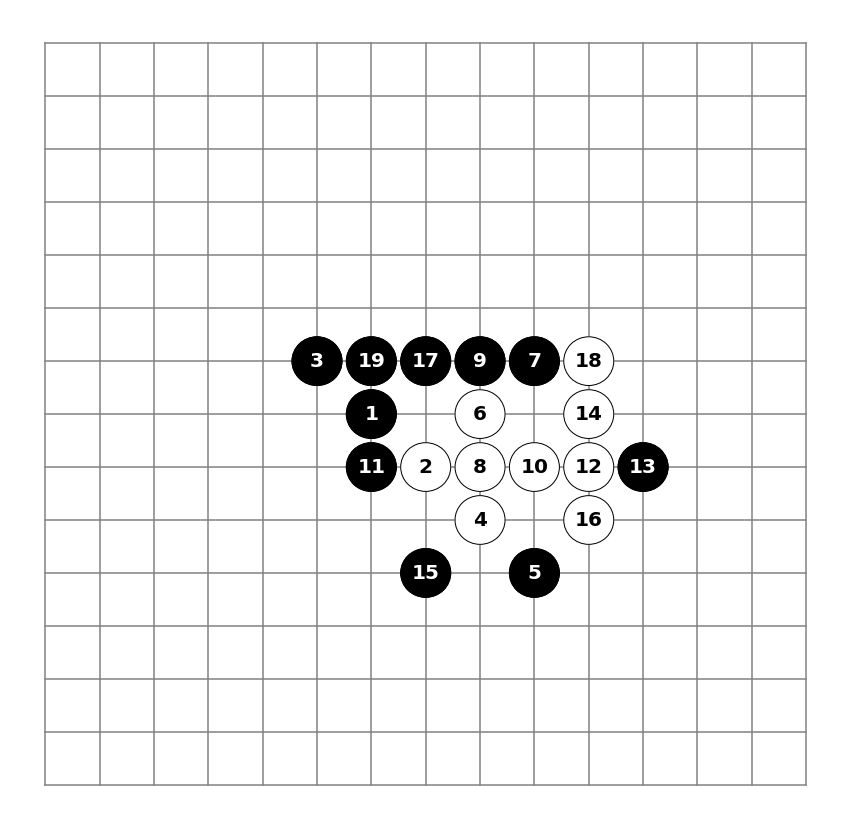

In [51]:
m = Mock5(H, W)
m.play(agent(policy_model(curr_pn)), m5df.agent,
  print_intermediate_state=False)
m.plot()
plt.show()
plt.close()

한번씩 위처럼 백18을 흑19자리에 둬서 방어를 해야하는데,
그러지 않아서 패배하는 경우를 확인할 수 있습니다.
이 경우가 알고리즘끼리 싸움에서는 그다지 나타나지 않아서
학습이 되지 않는, 일종의 탐색의 문제라고 보입니다.

In [ ]:
m = Mock5(H, W)
m.play(agent(policy_model(curr_pn)))

In [ ]:
m.plot()
plt.show()